# 01_OPERA_phase_unwrap

Here, we introduce the concept of Interferometric Synthetic Aperture Radar (InSAR) and the difficulties in measuring accurate phase differences. In our case, we want these phase differences to act as an estimation for snow water equivalent but this notebook is more of an overview of what exactly phase differences are and how they're present in our data

Please reference the holy grail (OPERA CSLC metadata) for more information:

https://d2pn8kiwq2w21t.cloudfront.net/documents/OPERA_CSLC-S1_ProductSpec_v1.0.0_D-108278_Initial_2023-09-11_URS321269.pdf

In [90]:
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from shapely.geometry import box
import numpy as np
import pandas as pd
from subprocess import call
import h5py
import matplotlib.pyplot as plt

### What is InSAR?

**Interferometric Synthetic Aperture Radar (InSAR)** is a remote sensing technique that commonly measures surface displacement by analyzing the phase difference between two radar images of the same area. These images are collected at different times using radar sensors on satellites. The fundamental idea behind InSAR is that the phase difference between corresponding pixels in two SAR images contains information about the movement of the Earth's surface in the line-of-sight direction of the radar sensor.

![InSAR Diagram](../images/insar_diagram.jpg)

The process begins with the acquisition of two radar images, commonly referred to as a "master" and "slave" images (but let's refer to them as a "source" image and a "second" image for obvious reasons), taken from essentially the same position in a satellite's orbit at different times. These images are compared to generate an **interferogram**, which captures the phase differences between the two radar signals. When the radar waves are reflected back to the sensor, they carry information about the distance between the satellite and the surface below. 

**Phase** refers to the position of a wave in its cycle. In the context of radar, it describes the relative position of the radar signal when it reaches the satellite's sensor. The **phase difference** between the signals from the two images measures the change in distance between the satellite and the surface - think of it as a measure of distance. When we talk about **wrapped phase**, we mean that the phase difference is confined to a specific range, usually between -π and π, due to the periodic nature of the radar signal. If the phase difference exceeds this range, it "wraps around" to stay within -π to π, causing the values to reset. This is called "wrapped" phase and how our data is stored:

$$
\varphi = W \left( \varphi_{\text{topography}} + \varphi_{\text{deformation}} + \varphi_{\text{atmosphere}} + \varphi_{\text{orbit}} + \varphi_{\text{noise}} \right)
$$

Where:
- $\varphi_{\text{topography}}$ represents the phase due to surface topography.
- $\varphi_{\text{deformation}}$ accounts for phase changes due to surface displacement.
- $\varphi_{\text{atmosphere}}$ includes phase shifts caused by atmospheric effects.
- $\varphi_{\text{orbit}}$ represents errors from satellite orbit inaccuracies.
- $\varphi_{\text{noise}}$ includes phase shifts from random noise.
- $W$ is the wrap operator that bounds the total phase between -π and π.

We want to isolate $\varphi_{\text{deformation}}$ as best as possible so we can get an accurate estimation of the "true" change in distance between the sensor and the surface between each acquisition. Luckily for us, NASA OPERA products are slay and the CSLC products we're using are rigorously corrected for each variable. In general, though, $\varphi_{\text{topography}}$ and $\varphi_{\text{atmosphere}}$ typically have the biggest influence in terms of error, whereas $\varphi_{\text{orbit}}$ and $\varphi_{\text{noise}}$ are more negligible.

TODO: provide references for tropospheric and topographic errors

In **InSAR**, the phase difference we're working towards by isolating $\varphi_{\text{deformation}}$ directly corresponds to **surface displacement**. This displacement, particularly in the **line-of-sight** direction of the sensor, is encoded in the wrapped phase. By **unwrapping** the phase, we can obtain continuous measurements of surface motion over a region, which is essential for monitoring phenomena such as **earthquakes**, **land subsidence**, and  **snow water equivalent** in our case. Unwrapping involves converting the wrapped phase (with values between -π and π) into a continuous map that reflects the true displacement, but more on that later in this notebook.

> [!NOTE]  
> Coregistration, the process of aligning two radar images so that they match perfectly in space, is a crucial step in InSAR. However, NASA's OPERA CSLC products have already undergone this process, so we will skip this step. For more information on coregistration and its importance, check out this https://earth.esa.int/eogateway/documents/20142/37627/Coregistration_Small_Baseline_InSAR_image_subsets_pointwise_targets.pdf

In [ ]:
# load in our wrapped phase data from 00_SAR_intro.ipynb
fn_1 = "/home/jehayes/sh_final/cslc/asc/OPERA_L2_CSLC-S1_T049-103322-IW2_20180103T010924Z_20240428T014600Z_S1B_VV_v1.1.h5"
fn_2 = "/home/jehayes/sh_final/cslc/asc/OPERA_L2_CSLC-S1_T049-103322-IW2_20180115T010923Z_20240428T051456Z_S1B_VV_v1.1.h5"

dsR = xr.open_dataset(fn_1,
                      group='data',
                      engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))
tR = pd.to_datetime(xr.open_dataset(fn_1, 
                                    group='identification')['zero_doppler_start_time'].data.astype('U')) # Unicode string format
dsS = xr.open_dataset(fn_2,
                      group='data',
                      engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))

tS = pd.to_datetime(xr.open_dataset(fn_2, group='identification')['zero_doppler_start_time'].data.astype('U'))

ifg = dsR * np.conj(dsS)
ifg.attrs['reference'] = tR
ifg.attrs['secondary'] = tS
da = xr.apply_ufunc(np.angle, ifg)
# this 'phase' variable is our $$\varphi$$ seen above (the wrapped phase)
ds = da.to_dataset(name='phase')
ds.rio.write_crs('EPSG:32613', inplace=True)

<xarray.Dataset> Size: 409MB
Dimensions:      (x: 20670, y: 4941)
Coordinates:
  * x            (x) float64 165kB 7.14e+05 7.14e+05 ... 8.173e+05 8.173e+05
  * y            (y) float64 40kB 4.218e+06 4.218e+06 ... 4.169e+06 4.169e+06
    spatial_ref  int64 8B 0
Data variables:
    phase        (y, x) float32 409MB nan nan nan nan nan ... nan nan nan nan

##### Topographic Phase and Its Removal

When generating an InSAR interferogram, one of the key contributors to the observed phase difference is the **topography** of the surface being observed. $\varphi_{\text{topography}}$ arises due to the variation in the elevation of the surface, which causes different radar signal paths to have different lengths. In simple terms, higher elevations increase the distance between the radar and the surface, while lower elevations reduce it. These differences create phase shifts that are purely due to topographical features, not due to any deformation or displacement of the surface.

The topographic phase is a common artifact in InSAR measurements because it distorts the true surface displacement signal. Without removing it, we would not be able to distinguish between actual displacement (such as due to land subsidence or earthquakes) and phase shifts that are simply caused by changes in surface elevation.

To isolate the true deformation signal, we need to **subtract the topographic phase**. This is typically done by using a reference Digital Elevation Model (DEM). The DEM provides a detailed map of the surface elevation and allows us to calculate the phase contribution due to topography at each point in the radar image. Once this topographic phase is modeled, it can be subtracted from the interferogram, leaving us with a phase signal that better represents the surface displacement (plus any residual errors, such as atmospheric phase shifts or noise).

The process works as follows:

1. **Generate the topographic phase**: Using the reference DEM, calculate the expected phase shift at each pixel based on the elevation.
$$ 
\varphi_{\text{topography}} = \frac{4\pi B h}{λ R \sin(\theta)} 
$$
- **$\lambda$**: Wavelength of the radar signal (in meters).
- **$4\pi$**: Constant factor used in the formula for calculating the topographic phase.
- **$h$**: Elevation of the surface from the Digital Elevation Model (DEM) (in meters).
- **$R$**: Radar line-of-sight distance from the sensor to the surface (in meters).
- **$\theta$**: Incidence angle of the radar signal (in radians).
2. **Subtract the topographic phase**: Remove the calculated topographic phase from the interferogram, which leaves a phase signal primarily due to displacement.

In our case, our reference DEM is the Copernicus 30 GLO-DEM at 30m spatial resolution and the topographic "flattening" is already done for us because the OPERA CSLC products are awesome. We just have to pull out this corrected phase from the metadata

This is done before unwrapping our phase since $\varphi_{\text{topography}}$ is itself a phase term expressed in radians and thus behaves the same way as the wrapped phase.

In [ ]:
# get topographically corrected flattening phase from both acquisitions
with h5py.File(fn_1, 'r') as f:
    flat_phase1 = f['data/flattening_phase'][()]
with h5py.File(fn_2, 'r') as f:
    flat_phase2 = f['data/flattening_phase'][()]
diff_flat_phase = flat_phase2 - flat_phase1

In [80]:
# Convert to xarray with same coordinates as original dataset
diff_flat_phase_da = xr.DataArray(
    diff_flat_phase,
    dims=['y', 'x'],
    coords={'y': ds.y, 'x': ds.x}
)

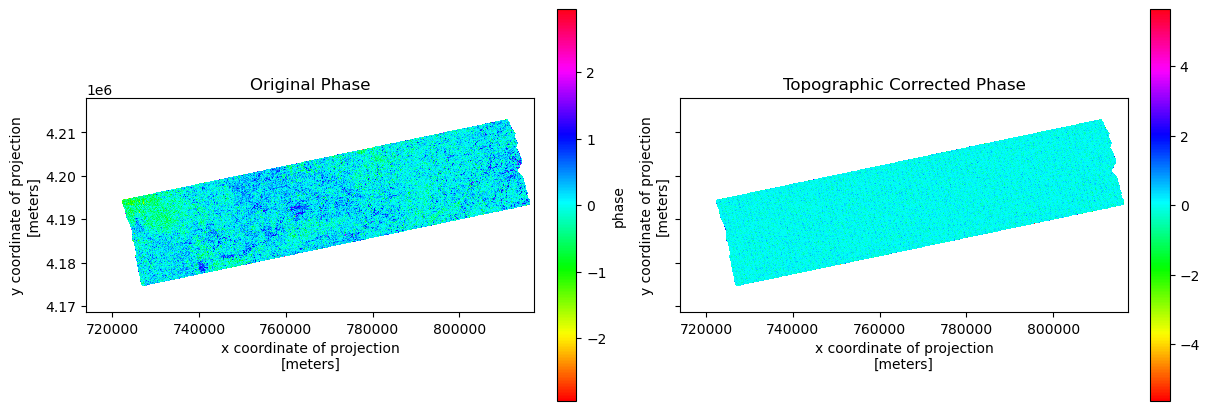

In [83]:
# plot with coarsening for quicker plots
nx = 16
ny = 8
f, axs = plt.subplots(1,2,figsize=(12,4), constrained_layout=True,
                      sharex=True, sharey=True)
ds.phase.coarsen(x=nx,y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=axs[0])
axs[0].set_title('Original Phase')
diff_flat_phase_da.coarsen(x=nx, y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=axs[1])
axs[1].set_title('Topographic Corrected Phase')

axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
plt.show()

> [!NOTE]  
> The original phase from returns values in the range [-π, π] because this is the principal value range for the arctangent function used to compute phase from complex numbers. The differential flattening phase spans [-2π, 2π] because it represents the difference between two phase measurements, which doubles the potential range of values.

> We also see that our topographic corrected phase has values close to 0. This is good and expected as you will see in the phase unwrapping section

##### Atmospheric Phase and Its Correction  

Another significant source of error in InSAR measurements is the **atmospheric phase delay** ($\varphi_{\text{atmosphere}}$). Atmospheric conditions, such as variations in temperature, pressure, and water vapor content, can affect the propagation of radar waves, introducing phase delays that are unrelated to surface displacement. These effects are particularly noticeable in regions with strong weather variability or significant topographic relief.  

Correcting for atmospheric phase delays is essential to obtain accurate deformation measurements. The process typically involves estimating the atmospheric contribution and subtracting it from the interferogram. This can be done using:  

1. **Empirical models**: Statistical methods based on external weather data or empirical corrections derived from multiple interferograms.  
2. **Numerical weather models**: High-resolution weather models, such as the ECMWF ERA5 or NASA's MERRA-2, can provide estimates of atmospheric delays at the time of radar acquisitions.  
3. **GPS and other auxiliary data**: Ground-based GPS stations and other remote sensing data (e.g., MODIS water vapor maps) can help refine atmospheric corrections.  

In practice, many modern InSAR products, including NASA OPERA CSLC datasets, come with pre-applied atmospheric corrections as we'll see below. However, residual atmospheric effects may still be present, particularly in challenging environments. For further details on atmospheric correction techniques, refer to **Ferretti et al. (2001)** and **Jolivet et al. (2014)**.

In [86]:
# Check reference image corrections
with h5py.File(fn_1, 'r') as f:
    dry_trop_ref = f['metadata/processing_information/parameters/dry_troposphere_weather_model_applied'][()]
    wet_trop_ref = f['metadata/processing_information/parameters/wet_troposphere_weather_model_applied'][()]
    static_trop_ref = f['metadata/processing_information/parameters/static_troposphere_applied'][()]
    print(f"Reference image corrections:")
    print(f"Dry troposphere: {dry_trop_ref}")
    print(f"Wet troposphere: {wet_trop_ref}") 
    print(f"Static troposphere: {static_trop_ref}")
# Check secondary image corrections
with h5py.File(fn_2, 'r') as f:
    dry_trop_sec = f['metadata/processing_information/parameters/dry_troposphere_weather_model_applied'][()]
    wet_trop_sec = f['metadata/processing_information/parameters/wet_troposphere_weather_model_applied'][()]
    static_trop_sec = f['metadata/processing_information/parameters/static_troposphere_applied'][()]
    print(f"\nSecondary image corrections:")
    print(f"Dry troposphere: {dry_trop_sec}")
    print(f"Wet troposphere: {wet_trop_sec}")
    print(f"Static troposphere: {static_trop_sec}")

Reference image corrections:
Dry troposphere: False
Wet troposphere: False
Static troposphere: True

Secondary image corrections:
Dry troposphere: False
Wet troposphere: False
Static troposphere: True


We see above that 'static troposphere' corrections were applied to both radar images. More on this in the OPERA CSLC metadata hyperlinked at the top of the notebook

##### Phase from Orbit and Its Impact

In InSAR measurements, another potential source of error is the **orbital phase** ($\varphi_{\text{orbit}}$), which arises due to the uncertainty in the satellite's position and motion during radar acquisition (as we have to know where the satellite is during both acquisitions to accurately calculate distance). The phase from orbit reflects differences in the satellite's actual position compared to its assumed position at the time of data acquisition, leading to small phase shifts in the interferogram. 

Orbital data can be divided into two types:

1. **Restituted orbits**: Quick, less accurate orbital data available shortly after acquisition, typically used for early processing and analysis. These orbits are computed from available tracking data but may contain small inaccuracies.
2. **Precise orbits**: Highly accurate orbital data available after several days or weeks, derived from more extensive tracking information and corrections. These orbits provide a much more accurate satellite position and are used for final, precise interferogram processing.

In most cases, errors due to orbital phase differences are negligible. The contribution of the phase from orbit is small compared to other sources of phase error, such as topographic or atmospheric effects. As a result, while orbital data accuracy is important, it typically does not significantly impact the final deformation measurements.

In [87]:
with h5py.File(fn_1, 'r') as f:
    orbit_type = f['metadata/orbit/orbit_type'][()]
    print(f"Reference image orbit type: {orbit_type}")

with h5py.File(fn_2, 'r') as f:
    orbit_type = f['metadata/orbit/orbit_type'][()]
    print(f"Secondary image orbit type: {orbit_type}")

Reference image orbit type: b'POEORB'
Secondary image orbit type: b'POEORB'


We see above that both radar images have precise orbits, minimizing the respective errors

##### Phase from Noise

Another source of error in InSAR measurements is **random noise** ($\varphi_{\text{noise}}$), which arises due to inherent sensor limitations, environmental factors, and other unpredictable influences during data acquisition. This noise introduces random phase variations that do not correspond to actual surface displacement.

However, the effect of random noise is typically negligible in well-processed interferograms, as noise tends to average out across multiple acquisitions or through appropriate filtering, leaving the true deformation signal intact.

In [89]:
with h5py.File(fn_1, 'r') as f:
    noise_files = f['metadata/processing_information/inputs/noise_files'][()]
    print(f"Reference image noise files:")
    print(noise_files)

with h5py.File(fn_2, 'r') as f:
    noise_files = f['metadata/processing_information/inputs/noise_files'][()]
    print(f"\nSecondary image noise files:")
    print(noise_files)

Reference image noise files:
b'noise-s1b-iw2-slc-vv-20180103t010859-20180103t010927-009000-010123-005.xml'

Secondary image noise files:
b'noise-s1b-iw2-slc-vv-20180115t010858-20180115t010926-009175-0106d2-005.xml'


And we see above the path to metadata files concerning noise corrections applied to each radar image. There are ways to quantify the phase error due to random noise, but that doesn't fit within the scope of this final project so we'll leave it at that

##### How do we Unwrap the Phase?

To actually get an interpretable deformation measurement, we neep to 'unwrap' the phase to obtain a continuous phase map. This involves integrating the phase differences between neighboring pixels. The unwrapped phase φ_unwrapped at a pixel (i, j) is given by:

$$
φ_{\text{unwrapped}}(i, j) = φ_{\text{wrapped}}(i, j) + 2π \sum_{k=1}^{i} \sum_{l=1}^{j} Δφ(k, l)
$$
https://hyp3-docs.asf.alaska.edu/guides/insar_product_guide

where Δφ(k, l) is the phase difference between neighboring pixels. Various algorithms, such as the Minimum Cost Flow method, are employed to perform phase unwrapping, aiming to minimize the total phase difference across the entire image.
https://www.gamma-rs.ch/uploads/media/2002-4_PhaseUnwrapping.pdf

This process is challenging, though, and many factors can affect the quality of the unwrapped phase map. For instance, noise, phase discontinuities (when phase differences are very large, the algorithm might mistakenly treat it as a jump of 2π), and path dependence (the sequence of pixels or data points traversed during the unwrapping process - the summation over neighboring pixels (k, l) can produce different results if the order or direction of integration changes) can all impact the accuracy of the unwrapping process.
https://igppweb.ucsd.edu/~fialko/insar/phase_unwrap.pdf
https://arxiv.org/abs/1806.01832

In [ ]:
# TODO: add more documentation for SNAPHU and typical softwares used and why it's different with OPERA
# still learning this...

In [91]:
# Prepare data for SNAPHU
# Coarsen the data first to make it more manageable
coarse_phase = diff_flat_phase_da.coarsen(x=nx, y=ny, boundary='trim').mean()

In [94]:
# Save the wrapped phase to a binary file
phase_file = '../dev_data/wrapped_phase.bin'
coarse_phase.values.astype(np.float32).tofile(phase_file)

In [107]:
# Create SNAPHU configuration file
config_file = '../dev_data/snaphu.conf'
with open(config_file, 'w') as f:
    f.write(f'INFILE {phase_file}\n')
    f.write(f'OUTFILE unwrapped_phase.bin\n')
    f.write('STATCOSTMODE TOPO\n')

In [ ]:
# TODO: fix SNAPHU

In [112]:
# Run SNAPHU with explicit dimensions (issues with conf file args)
# https://github.com/luke-webber/snaphu/blob/master/config/snaphu.conf.full
nrows, ncols = coarse_phase.shape
call(f'snaphu -f {config_file} {phase_file} {ncols}', shell=True)


snaphu v2.0.5
3 parameters input from file ../dev_data/snaphu.conf (3 lines total)


line length must be positive integer


1